In [1]:
%reload_ext autoreload
%autoreload 2

from google.colab import drive
drive.mount('/content/drive')

import os
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'My_AI4Top/Top-invar-DL'
GOOGLE_DRIVE_PATH = os.path.join(
    'drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(GOOGLE_DRIVE_PATH)

import sys
sys.path.append(GOOGLE_DRIVE_PATH)

import torch
if torch.cuda.is_available:
    device = 'cuda'
    print('Good to go')
else:
    device = 'cpu'
    print('Please set Gpu via Edit -> Notebook Setting')


Mounted at /content/drive
drive/My Drive/My_AI4Top/Top-invar-DL
Good to go


In [ ]:
!git clone --branch dev https://github.com/Junang-Wang/Top-invar-DL.git

(1, 2, 3, 1, 2, 3)

In [ ]:
del Graphene_params
del Graphene_SS_Gen



In [ ]:
torch.cuda.empty_cache()
torch.cuda.memory_allocated()

847269376

In [2]:
from Graphene_Generator_v3_Gpu import *
torch.cuda.empty_cache()
device = 'cuda'
t = torch.arange(10,52,20)
#t = torch.tensor([16])
t_unique = t.shape[0]

Delta = 1
B_steps = 25
mu_steps = 25
mu_random = 10
B = torch.linspace(-5,5,B_steps)
mu_0 = torch.linspace(0,10,mu_random)
mu_offset = torch.linspace(-5,5,mu_steps)
mu_truck = 1
mu_div = mu_random//mu_truck
nx, ny = 1500, 1500
Graphene_D = torch.zeros(t_unique,mu_random,mu_steps,B_steps)
for i in range(t_unique):
    for j in range(mu_div):
        Graphene_params = Graphene_Vec(t[i:i+1], mu_0[j*mu_truck:(j+1)*mu_truck], mu_offset, B, nx, ny, Delta, device='cuda')
        Graphene_SS_Gen = Graphene_SS(Graphene_params,device='cuda')
        Graphene_D[i,j*mu_truck:(j+1)*mu_truck] = Graphene_SS_Gen.total()
        del Graphene_params
        del Graphene_SS_Gen
        torch.cuda.empty_cache()
    if j == mu_div-1 and mu_random%mu_truck != 0:
        Graphene_params = Graphene_Vec(t[i:i+1], mu_0[(j+1)*mu_truck:], mu_offset, B, nx, ny, Delta, device='cuda')
        Graphene_SS_Gen = Graphene_SS(Graphene_params,device='cuda')
        Graphene_D[i,(j+1)*mu_truck:] = Graphene_SS_Gen.total()
        del Graphene_params
        del Graphene_SS_Gen
        torch.cuda.empty_cache()

Graphene_labels = torch.cat((2*torch.ones(mu_random*t_unique,1),mu_0.reshape(-1,1).repeat(t_unique,1)),dim=1)

Graphene_D = Graphene_D.reshape(t_unique*mu_random,1,B_steps,mu_steps)



torch.Size([1, 1, 25, 25])
torch.Size([1, 1, 25, 25])
torch.Size([1, 1, 25, 25])
torch.Size([1, 1, 25, 25])
torch.Size([1, 1, 25, 25])


In [5]:
print(Graphene_D.shape)
print(Graphene_D.max())
print(Graphene_D.min())

torch.Size([3, 101, 25, 25])
tensor(2.6398)
tensor(-1.5223)


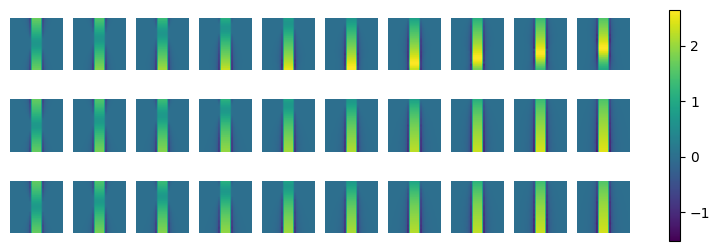

In [6]:
import matplotlib.pyplot as plt
#t_unique = 21
t_unique = 3
mu_random = 101
Graphene_D = Graphene_D.reshape(t_unique,mu_random,25,25)
t_show = t_unique
mu_show = 10
fig, ax = plt.subplots(t_show,mu_show)
fig.set_figwidth(mu_show)
fig.set_figheight(t_show)

# vmax = 5
# vmin = -5
vmax = torch.max(Graphene_D).item()
vmin = torch.min(Graphene_D).item()
for i in range(t_show):
  for j in range(mu_show):
    im = ax[i,j].imshow(Graphene_D[i,10*j],vmax=vmax,vmin=vmin)
    #im = ax[j].imshow(Graphene_D[t_show*i,j],vmax=vmax,vmin=vmin)

    ax[i,j].axis('off')
    # if i == 0: #first row
    #   fig.text(i,j,f'{Graphene_labels[5*i*10*j,1].item():.1f}')
    # if j == 0: #first col:
    #   fig.text(i,j,f'{Graphene_labels[5*i*10*j,0].item():.1f}')

plt.colorbar(im,ax=ax)
plt.show()

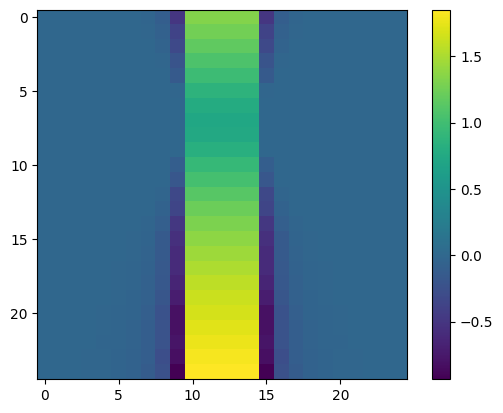

In [7]:
plt.imshow(Graphene_D[2,20])
plt.colorbar()

In [ ]:
Graphene_D_path = os.path.join(GOOGLE_DRIVE_PATH,'Graphene_D.pt')
Graphene_label_path = os.path.join(GOOGLE_DRIVE_PATH,'Graphene_label.pt')
torch.save(Graphene_D,Graphene_D_path)
torch.save(Graphene_labels,Graphene_label_path)

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib
kx, ky = Graphene_params.kx.reshape(-1), Graphene_params.ky.reshape(-1)
#epsilon = Graphene_params.epsilon_0.reshape(nx, ny)
x, y = torch.meshgrid(kx, ky, indexing='ij')
#ax = plt.axes(projection='3d')
def plot_epsilon(t):
    epsilon = t*torch.sqrt(abs(3+2*torch.cos(sqrt(3)*y) + 4 *
                  torch.cos(sqrt(3)/2*y)*torch.cos(3/2*x)))
    masker_epsilon_cutoff = torch.zeros_like(epsilon)
    masker_epsilon_cutoff[epsilon <=1000] = 1

    masked_epsilon = masker_epsilon_cutoff*epsilon
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    surf = ax.plot_surface(x, y, masked_epsilon, cmap=matplotlib.cm.coolwarm)
    cset = ax.contourf(x,y,epsilon,zdir='z',offset = 0,cmap=matplotlib.cm.coolwarm)
    fig.colorbar(surf,ax=ax)
    plt.show()
    #ax.clear()



In [ ]:
%matplotlib widget
import ipywidgets
ipywidgets.interact(plot_epsilon,t=10000)
#plt.show()

interactive(children=(IntSlider(value=10000, description='t', max=30000, min=-10000), Output()), _dom_classes=…

<function __main__.plot_epsilon(t)>